In [1]:
%load_ext autoreload
%autoreload 2

import cv2
from matplotlib import pyplot as plt
import numpy as np
import scipy.linalg

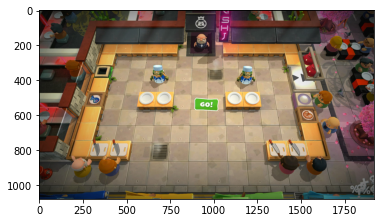

In [2]:
# Load image and interactive view to identify keypoints

img_path = "./overcooked.png"
img_frame = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_RGB2BGR)

# Press any key to close pop-up
cv2.imshow("image", cv2.cvtColor(img_frame, cv2.COLOR_RGB2BGR))
cv2.waitKey(0)
cv2.destroyAllWindows()

plt.imshow(img_frame)

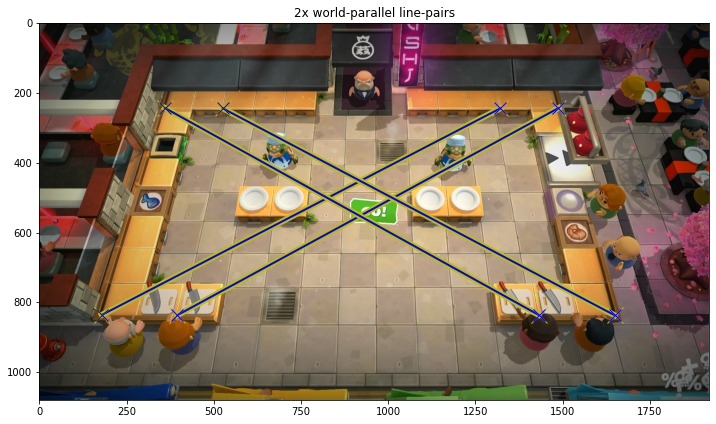

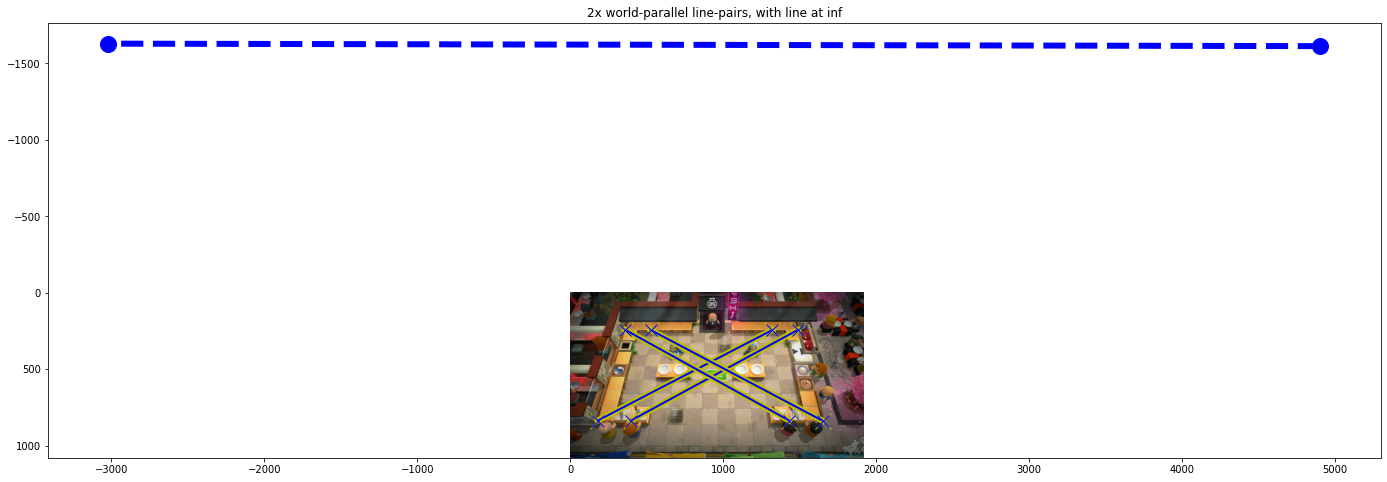

line_inf_homo after applying H_P^-T: [0. 0. 1.]


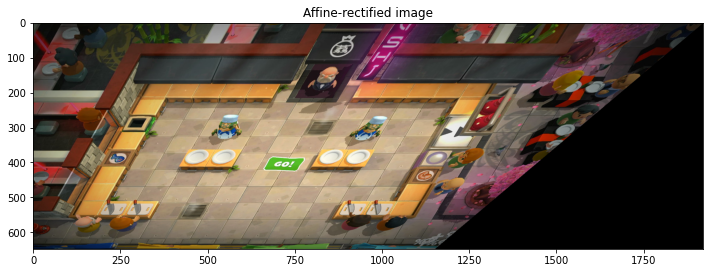

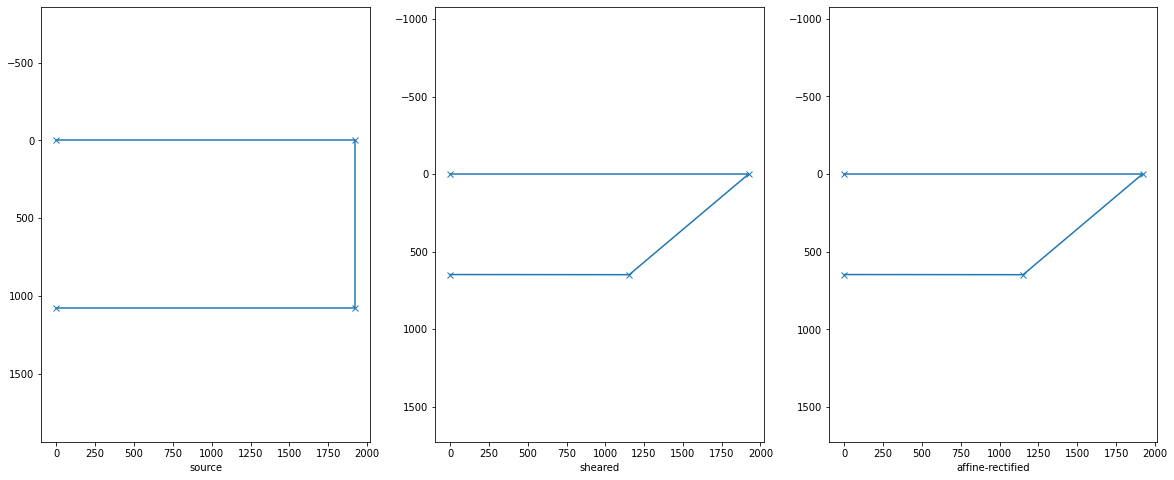

In [3]:
## Example 2.18: Affine rectification (using 2x world-parallel line-pairs to obtain l_inf)

# 0. Specify 2x of world-parallel line-pairs
# Representation: x1, y1, x2, y2
lines_xy = (
    (179, 836, 1321, 244),
    (395, 837, 1488, 243),
    (1431, 836, 360, 243),
    (1649, 837, 526, 244),

    # BEWARE: avoid using 4 world-colinear lines, as below,
    #         since their pt_inf will be too close to accurately solve line_inf
    # (178, 837, 361, 244),
    # (395, 836, 526, 247),
    # (1431, 830, 1322, 246),
    # (1650, 837, 1489, 243),
)

# 0. Visualize input
plt.figure(figsize=(12, 8))
plt.imshow(img_frame)
for x1, y1, x2, y2 in lines_xy:
    xs = (x1, x2)
    ys = (y1, y2)
    plt.plot(xs, ys, "-y", linewidth=6)
    plt.plot(xs, ys, "-b", linewidth=2)
    plt.plot(xs, ys, "xy", markersize=16, linewidth=6)
    plt.plot(xs, ys, "xb", markersize=12, linewidth=2)
plt.title("2x world-parallel line-pairs")
plt.show()

# 1. Transform into homogeneous coordinates
lines_homo = np.array(lines_xy)
x1s, y1s, x2s, y2s = lines_homo[:, 0], lines_homo[:, 1], lines_homo[:, 2], lines_homo[:, 3]
lines_homo = np.array((y1s - y2s, x2s - x1s, x1s * y2s - x2s * y1s))  # 3x4
lines_homo = lines_homo / np.expand_dims(lines_homo[2, :], axis=0)

# np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})
# print(f"2x world-parallel line-pairs in homogeneous coords (column vectors):\n{lines_homo}")
# np.set_printoptions(formatter=None)

# 2. Compute intersections for the pairs of lines, then join them to obtain line_inf
pt1_inf_homo = np.cross(lines_homo[:, 0], lines_homo[:, 1])
pt1_inf_homo /= pt1_inf_homo[2]
pt2_inf_homo = np.cross(lines_homo[:, 2], lines_homo[:, 3])
pt2_inf_homo /= pt2_inf_homo[2]
line_inf_homo = np.cross(pt1_inf_homo, pt2_inf_homo)
line_inf_homo /= line_inf_homo[2]

# 2. Visualize line at infinity
# print(f"pt1_inf_xy: {pt1_inf_homo[:2].astype(int)}")
# print(f"pt2_inf_xy: {pt2_inf_homo[:2].astype(int)}")
# print(f"line_inf_homo in source image: {line_inf_homo}")
plt.figure(figsize=(24, 8))
plt.imshow(img_frame)
for x1, y1, x2, y2 in lines_xy:
    xs = (x1, x2)
    ys = (y1, y2)
    plt.plot(xs, ys, "-y", linewidth=6)
    plt.plot(xs, ys, "-b", linewidth=2)
    plt.plot(xs, ys, "xy", markersize=16, linewidth=6)
    plt.plot(xs, ys, "xb", markersize=12, linewidth=2)
plt.plot((pt1_inf_homo[0], pt2_inf_homo[0]), (pt1_inf_homo[1], pt2_inf_homo[1]), "--bo", markersize=16, linewidth=6)
plt.title("2x world-parallel line-pairs, with line at inf")
plt.show()

# 3. Obtain shear (a.k.a. perspective) component of homography,
#    which rectifies x' (perspective-warped) into x (affine-warped)
H_P = np.eye(3)
H_P[2, :] = line_inf_homo
H_P_inv_trans = np.linalg.inv(H_P).transpose()

# 3. Sanity check: H_P should transform line_inf_homo into canonical line_inf
line_inf_sheared_homo = H_P_inv_trans @ line_inf_homo
line_inf_sheared_homo /= line_inf_sheared_homo[2]
dist_from_canonical_line_inf = np.linalg.norm(line_inf_sheared_homo - np.array((0, 0, 1)))
assert(dist_from_canonical_line_inf <= 1e-10), f"H_P not exactly transforming line_inf_homo to (0, 0, 1)"
print(f"line_inf_homo after applying H_P^-T: {line_inf_sheared_homo}")

# 4. At this point, we need to determine how large is the target canvas, and which parts
# of the H-projected source image will fit within the target canvas

# 4-A: choose H_A's scaling and translation to ensure that corners
# of the source image will be within the target canvas
h, w = img_frame.shape[:2]
pts_homo = np.array((
    (0, w, w, 0),
    (0, 0, h, h),
    (1, 1, 1, 1)
))

# 4-B: choose H_A's scaling and translation to ensure that corners
# of the source image will be within the target canvas
# lines_homo = np.array(lines_xy)
# x1s, y1s, x2s, y2s = lines_homo[:, 0], lines_homo[:, 1], lines_homo[:, 2], lines_homo[:, 3]
# xs = np.concatenate((x1s, x2s))
# ys = np.concatenate((y1s, y2s))
# ones = np.ones((1, 8))
# pts_homo = np.vstack((xs, ys, ones))

pts_sheared_homo = H_P @ pts_homo
pts_sheared_homo = pts_sheared_homo / np.expand_dims(pts_sheared_homo[2, :], axis=0)

xs_sheared = pts_sheared_homo[0, :]
ys_sheared = pts_sheared_homo[1, :]
x_min_sheared = np.min(xs_sheared)
x_max_sheared = np.max(xs_sheared)
y_min_sheared = np.min(ys_sheared)
y_max_sheared = np.max(ys_sheared)
width_sheared = x_max_sheared - x_min_sheared
height_sheared = y_max_sheared - y_min_sheared

# 4. Define affine component of homography given desired target canvas dimensions
width_target = img_frame.shape[1]  # arbitrary user choice
scale_affine = width_target / width_sheared
rotation_affine_rad = 0
height_target = int(np.ceil(height_sheared * scale_affine))
H_SA = scale_affine * np.array((
    (np.cos(rotation_affine_rad), -np.sin(rotation_affine_rad), -x_min_sheared),
    (np.sin(rotation_affine_rad),  np.cos(rotation_affine_rad), -y_min_sheared),
    (0,                           0,                            1/scale_affine)
))
H_affine_rect = H_SA @ H_P
H_affine_rect /= H_affine_rect[2, 2]

# 4. Sanity check: H should transform pts_homo into bounding box (width_target, height_target)
pts_affine_rect_homo = H_affine_rect @ pts_homo
pts_affine_rect_homo = pts_affine_rect_homo / np.expand_dims(pts_affine_rect_homo[2, :], axis=0)
pts_affine_rect_xy = np.floor(pts_affine_rect_homo[:2, :]).astype(int)
fudge_px = 1
assert(0-fudge_px <= np.min(pts_affine_rect_xy[0, :]) <= np.max(pts_affine_rect_xy[0, :]) <= width_target+fudge_px), "pts_affine_rect not within width bounds"
assert(0-fudge_px <= np.min(pts_affine_rect_xy[1, :]) <= np.max(pts_affine_rect_xy[1, :]) <= height_target+fudge_px), "pts_affine_rect not within height bounds"

# 5. Warp source image into target canvas
img_affine_rect = cv2.warpPerspective(img_frame, H_affine_rect, dsize=(width_target, height_target))

plt.figure(figsize=(12, 8))
plt.imshow(img_affine_rect)
plt.title("Affine-rectified image")
plt.show()

# 5. visualize how the source and transformed points look like
plt.figure(figsize=(20, 8))

plt.subplot(1, 3, 1)
plt.plot(pts_homo[0, :], pts_homo[1, :], "x-")
plt.axis("equal")
plt.gca().invert_yaxis()
plt.xlabel("source")

plt.subplot(1, 3, 2)
plt.plot(pts_sheared_homo[0, :], pts_sheared_homo[1, :], "x-")
plt.axis("equal")
plt.gca().invert_yaxis()
plt.xlabel("sheared")

plt.subplot(1, 3, 3)
plt.plot(pts_affine_rect_homo[0, :], pts_affine_rect_homo[1, :], "x-")
plt.axis("equal")
plt.gca().invert_yaxis()
plt.xlabel("affine-rectified")

plt.show()

# print(f"pts = {pts_homo[:2, :].astype(int)}")
# print(f"pts_sheared = {pts_sheared_homo[:2, :].astype(int)}")
# print(f"pts_target = {pts_affine_rect_homo[:2, :].astype(int)}")

In [4]:
## Interactive view affine-corrected image to identify keypoints on img_affine_rect, for below

# Press any key to close pop-up
cv2.imshow("image", cv2.cvtColor(img_affine_rect, cv2.COLOR_RGB2BGR))
cv2.waitKey(0)
cv2.destroyAllWindows()

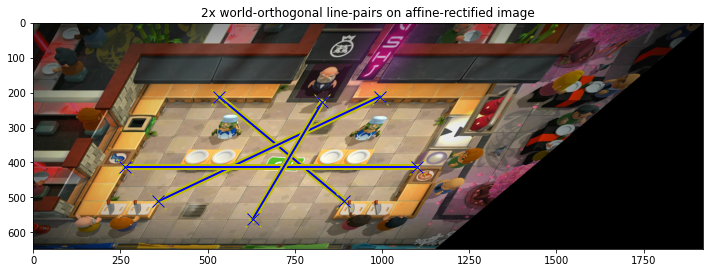

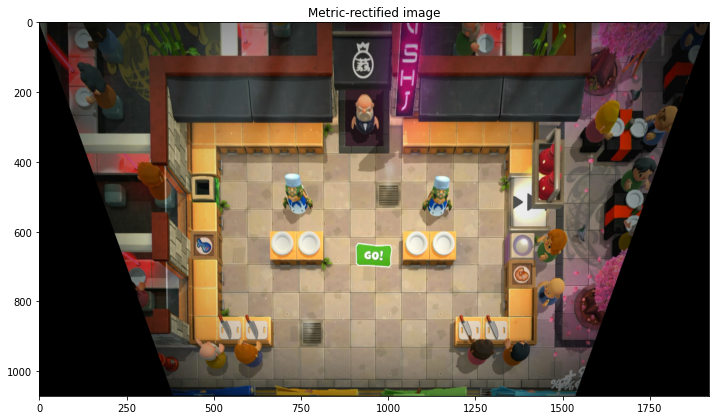

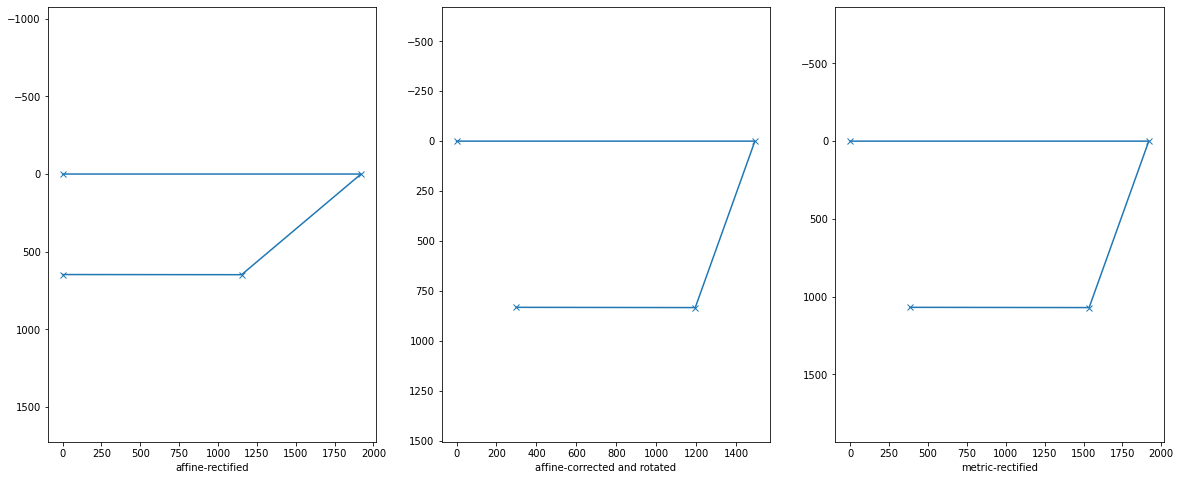

In [5]:
## Example 2.26: Metric rectification I

# 0. Define 2 non-parallel world-orthogonal line-pairs
# Representation: x1, y1, x2, y2
lines_ortho_xy = (
    (533, 212, 891, 510),
    (994, 211, 359, 511),
    (264, 412, 1101, 412),
    (629, 563, 828, 228),  # world-vertical line
    # (113, 535, 202, 495),
    # (137, 497, 174, 534),
    # (832, 529, 1040, 528),
    # (977, 526, 1068, 399),
)

# 0. Visualize input
plt.figure(figsize=(12, 8))
plt.imshow(img_affine_rect)
for x1, y1, x2, y2 in lines_ortho_xy:
    xs = (x1, x2)
    ys = (y1, y2)
    plt.plot(xs, ys, "-y", linewidth=6)
    plt.plot(xs, ys, "-b", linewidth=2)
    plt.plot(xs, ys, "xy", markersize=16, linewidth=6)
    plt.plot(xs, ys, "xb", markersize=12, linewidth=2)
plt.title("2x world-orthogonal line-pairs on affine-rectified image")
plt.show()

# 1. Transform into homogeneous coordinates
lines_ortho_homo = np.array(lines_ortho_xy)
x1s, y1s, x2s, y2s = lines_ortho_homo[:, 0], lines_ortho_homo[:, 1], lines_ortho_homo[:, 2], lines_ortho_homo[:, 3]
lines_ortho_homo = np.array((y1s - y2s, x2s - x1s, x1s * y2s - x2s * y1s))  # 3x4
lines_ortho_homo = lines_ortho_homo / np.expand_dims(lines_ortho_homo[2, :], axis=0)

# np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})
# print(f"2x world-orthogonal line-pairs in homogeneous coords (column vectors):\n{lines_ortho_homo}")
# np.set_printoptions(formatter=None)

# 2. Solve for S (2x2 matrix) via null-space / SVD
la, ma, lb, mb = lines_ortho_homo[:2, 0], lines_ortho_homo[:2, 1], lines_ortho_homo[:2, 2], lines_ortho_homo[:2, 3]
LM = np.array((  # LM * (s11, s12, s22)^T = 0
    (la[0]*ma[0], la[0]*ma[1] + la[1]*ma[0], la[1]*ma[1]),
    (lb[0]*mb[0], lb[0]*mb[1] + lb[1]*mb[0], lb[1]*mb[1]),
))
Svec = scipy.linalg.null_space(LM).flatten()
S = np.array((
    (Svec[0], Svec[1]),
    (Svec[1], Svec[2]),
))
S /= np.sqrt(np.linalg.det(S))  # S should have det == 1, since in eqn. 2.16 K also needs det == 1

# print(f"S = \n{S}")

# 2. Sanity check: S should satisfy orthogonality constraint for world-orthogonal line-pairs
assert(np.abs(la @ S @ ma) <= 1e-10), "S does not satisfy first line-pair's orthogonality constraint"
assert(np.abs(lb @ S @ mb) <= 1e-10), "S does not satisfy second line-pair's orthogonality constraint"

# 3. Solve for affine K s.t. S = K @ K^T
# NOTE: the book defines x' = H * x, where x is the Euclidean (a.k.a. world) space, and x' is the
#       perspective-warped space. That means that whereas the book defines K and correspondingly H_A
#       to project x into x', in this script we define H_A oppositely, to rectify x' back into x.
# NOTE: the book is possibly in error, since eqn 2.16 defines K as upper-triangular, but example 2.26
#       defines S as K @ K^T and says K can be solved using Cholesky decomposition, which
#       is a LOWER-triangular @ upper-triangular decomposition.
K = scipy.linalg.cholesky(S, lower=True)
H_A_inv = np.eye(3)
H_A_inv[:2, :2] = K
H_A = np.linalg.inv(H_A_inv)

# print(f"H_A = \n{H_A}")

# 3. Sanity check: K should satisfy orthogonality constraint for world-orthogonal line-pairs
# NOTE: since K is defined by the book as projecting x (Euclidean/world coords) into x' (perspective-warped),
#       K^-1 takes x' into x, and so (K^-1)^-T takes e.g. la (perspective-warped) into rectified coordinates.
#       That's why we apply K.transpose() / K to ma / la.
assert(np.abs((la @ K) @ (K.transpose() @ ma)) <= 1e-10), "K does not satisfy first line-pair's orthogonality constraint"
assert(np.abs((lb @ K) @ (K.transpose() @ mb)) <= 1e-10), "K does not satisfy second line-pair's orthogonality constraint"

# Define (arbitrary) similarity matrix H_S such that desired content is in final canvas
# We do this in 2 steps:
# 4. figure out rotation such that world-vertical line should be image-vertical
# 5. determine scaling and translation based on the final canvas' dimensions

# 4. Given a world-vertical line, apply H_A to it and measure its orientation, then choose rotation that undo it
wvline_homo = lines_ortho_homo[:, 3]  # wvline: world-vertical line
wvline_trans_homo = H_A_inv.transpose() @ wvline_homo
rot_trans = np.arctan2(1/wvline_trans_homo[0], -1/wvline_trans_homo[1])  # convention: 0'=up (-y), 90'=right (+x)
rotation_simi_rad = rot_trans
H_rot = np.array((
    (np.cos(rotation_simi_rad), -np.sin(rotation_simi_rad), 0),
    (np.sin(rotation_simi_rad), np.cos(rotation_simi_rad), 0),
    (0, 0, 1),
))

# 5. Choose scaling and translation to ensure that corners of the source image will be within the final canvas
pts_affine_rect_homo = H_affine_rect @ pts_homo
pts_affine_rect_homo = pts_affine_rect_homo / np.expand_dims(pts_affine_rect_homo[2, :], axis=0)
pts_trans_homo = H_rot @ H_A @ pts_affine_rect_homo
pts_trans_homo = pts_trans_homo / np.expand_dims(pts_trans_homo[2, :], axis=0)

xs_trans = pts_trans_homo[0, :]
ys_trans = pts_trans_homo[1, :]
x_min_trans = np.min(xs_trans)
x_max_trans = np.max(xs_trans)
y_min_trans = np.min(ys_trans)
y_max_trans = np.max(ys_trans)
width_trans = x_max_trans - x_min_trans
height_trans = y_max_trans - y_min_trans

width_final = img_affine_rect.shape[1]  # arbitrary user choice
scale_simi = width_final / width_trans
height_final = int(np.ceil(height_trans * scale_simi))
H_scale_trans = np.array((
    (scale_simi, 0, -x_min_trans),
    (0, scale_simi, -y_min_trans),
    (0, 0, 1)
))

H_S = H_scale_trans @ H_rot
H_metric_rect = H_S @ H_A
H_metric_rect /= H_metric_rect[2, 2]

# 5. Sanity check: H should transform pts_sheared_homo into bounding box (width_final, height_final)
pts_metric_rect_homo = H_metric_rect @ pts_affine_rect_homo
pts_metric_rect_homo = pts_metric_rect_homo / np.expand_dims(pts_metric_rect_homo[2, :], axis=0)
pts_metric_rect_xy = np.floor(pts_metric_rect_homo[:2, :]).astype(int)
fudge_px = 1
assert(0-fudge_px <= np.min(pts_metric_rect_xy[0, :]) <= np.max(pts_metric_rect_xy[0, :]) <= width_final+fudge_px), "pts_metric_rect not within width bounds"
assert(0-fudge_px <= np.min(pts_metric_rect_xy[1, :]) <= np.max(pts_metric_rect_xy[1, :]) <= height_final+fudge_px), "pts_metric_rect not within height bounds"

# 6. Warp source image into final canvas
img_metric_rect = cv2.warpPerspective(img_affine_rect, H_metric_rect, dsize=(width_final, height_final))

plt.figure(figsize=(12, 8))
plt.imshow(img_metric_rect)
plt.title("Metric-rectified image")
plt.show()

# 7. visualize how the source and transformed points look like
plt.figure(figsize=(20, 8))

plt.subplot(1, 3, 1)
plt.plot(pts_affine_rect_homo[0, :], pts_affine_rect_homo[1, :], "x-")
plt.axis("equal")
plt.gca().invert_yaxis()
plt.xlabel("affine-rectified")

plt.subplot(1, 3, 2)
plt.plot(pts_trans_homo[0, :], pts_trans_homo[1, :], "x-")
plt.axis("equal")
plt.gca().invert_yaxis()
plt.xlabel("affine-corrected and rotated")

plt.subplot(1, 3, 3)
plt.plot(pts_metric_rect_homo[0, :], pts_metric_rect_homo[1, :], "x-")
plt.axis("equal")
plt.gca().invert_yaxis()
plt.xlabel("metric-rectified")

plt.show()

# print(f"pts = {pts_homo[:2, :].astype(int)}")
# print(f"pts_trans_homo = {pts_trans_homo[:2, :].astype(int)}")
# print(f"pts_metric_rect = {pts_metric_rect_homo[:2, :].astype(int)}")

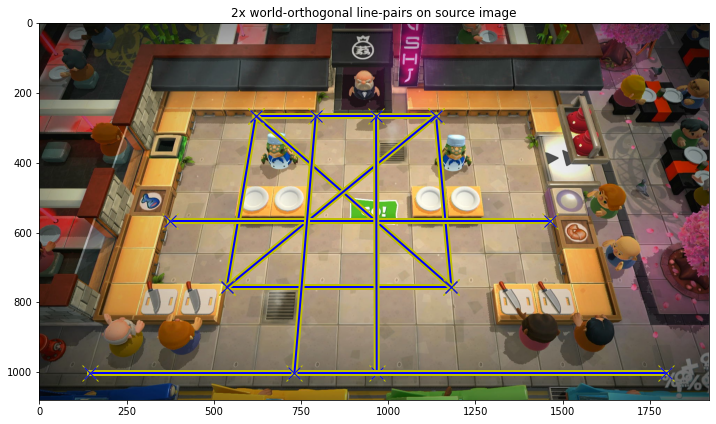

DEBUG-w/h: 1920/1016
DEBUG-x: 0 <= 1920
DEBUG-y: 0 <= 1015


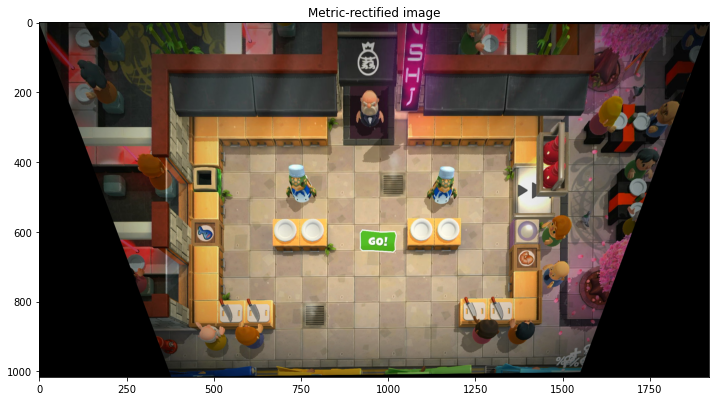

In [8]:
## Example 2.27: Metric rectification II

# 0. Define 5 non-parallel world-orthogonal line-pairs
# Representation: x1, y1, x2, y2
lines_ortho_xy = (
    (537, 757, 620, 265),  # bottom-left L / (world-verical line)
    (537, 757, 1181, 757), # ^^^
    (1137, 265, 620, 265),  # top-right 7
    (1137, 265, 1181, 757), # ^^^
    (620, 265, 1181, 757), # X
    (1137, 265, 537, 757), # ^^^
    (374, 568, 1463, 568), # cross
    (965, 265, 967, 1003), # ^^^
    (145, 1003, 1796, 1003), # upside-down T
    (792, 265, 731, 1003),   # ^^^

    # NOTE: the following set of line-pairs are too local (i.e. their endpoint pixels are too nearby), 
    #       which leads to poor global consistency in rectification
    # (178, 837, 507, 837), # bottom-left L
    # (178, 837, 265, 553), # ^^^ (world-vertical line)
    # (178, 837, 304, 747), # bottom-left X
    # (207, 746, 279, 837), # ^^^
    # (1645, 836, 1317, 837), # bottom-right L
    # (1645, 836, 1596, 645), # ^^^
    # (1166, 467, 1274, 551), # mid-right n
    # (1166, 467, 1071, 550), # ^^^
    # (663, 551, 575, 467), # mid-left V
    # (663, 551, 770, 467), # ^^^
)

# 0. Visualize input
plt.figure(figsize=(12, 8))
plt.imshow(img_frame)
for x1, y1, x2, y2 in lines_ortho_xy:
    xs = (x1, x2)
    ys = (y1, y2)
    plt.plot(xs, ys, "-y", linewidth=6)
    plt.plot(xs, ys, "-b", linewidth=2)
    plt.plot(xs, ys, "xy", markersize=16, linewidth=6)
    plt.plot(xs, ys, "xb", markersize=12, linewidth=2)
plt.title("2x world-orthogonal line-pairs on source image")
plt.show()

# 1. Transform into homogeneous coordinates
lines_ortho_homo = np.array(lines_ortho_xy)
x1s, y1s, x2s, y2s = lines_ortho_homo[:, 0], lines_ortho_homo[:, 1], lines_ortho_homo[:, 2], lines_ortho_homo[:, 3]
lines_ortho_homo = np.array((y1s - y2s, x2s - x1s, x1s * y2s - x2s * y1s))  # 3x4
lines_ortho_homo = lines_ortho_homo / np.expand_dims(lines_ortho_homo[2, :], axis=0)

# 2. Solve for C_inf_dual (3x3 orthogonal matrix) via null-space / SVD
LM = []
for i in range(5):
    l = lines_ortho_homo[:, 2*i]
    m = lines_ortho_homo[:, 2*i+1]
    LM.append((
        l[0]*m[0],
        (l[0]*m[1] + l[1]*m[0])/2,
        l[1]*m[1],
        (l[0]*m[2] + l[2]*m[0])/2,
        (l[1]*m[2] + l[2]*m[1])/2,
        l[2]*m[2],
    ))
LM = np.array(LM)
Cvec = scipy.linalg.null_space(LM).flatten()
C_inf_dual = np.array((
    (Cvec[0], Cvec[1]/2, Cvec[3]/2),
    (Cvec[1]/2, Cvec[2], Cvec[4]/2),
    (Cvec[3]/2, Cvec[4]/2, Cvec[5]),
))
C_inf_dual /= C_inf_dual[2, 2]

# print(f"C_inf_dual = \n{C_inf_dual}")

# 2. Sanity check: C_inf_dual should satisfy orthogonality constraint for world-orthogonal line-pairs
for i in range(5):
    l = lines_ortho_homo[:, 2*i]
    m = lines_ortho_homo[:, 2*i+1]
    residual = np.abs(l @ C_inf_dual @ m)
    assert(residual <= 1e-8), f"C_inf_dual does not satisfy {i+1}-th line-pair's orthogonality constraint"

# 3. Solve for affine K s.t. S = K @ K^T, and projectivity v (1 x 2), then define H_A and H_P
# NOTE: the book's definitions of K, v, H_A, and H_P all transform x (Euclidean/world coords) into
#       x' (projective-warped coords). In this cell, we care about the opposite, i.e. rectifying x'
#       into x. So, we shall follow the book's notation for K and v, but assume the inverse transforms
#       for H_A and H_P.
# NOTE: even though C_inf_dual is defined up to an arbitrary scale due to homogeneity invariance,
#       because we need K (and hence S) to have det == 1, we can solve for a unique v that matches K
S = C_inf_dual[:2, :2]
norm_S = np.sqrt(np.linalg.det(S))
S = S / norm_S  # S should have det == 1, since in eqn. 2.16 K also needs det == 1
norm_v = 1/np.sqrt(norm_S)

K = scipy.linalg.cholesky(S, lower=True)
H_A_inv = np.eye(3)
H_A_inv[:2, :2] = K

v = norm_v * norm_v * C_inf_dual[2, :2] @ np.linalg.inv(K).transpose()
H_P_inv = np.eye(3)
H_P_inv[2, :2] = v

H_AP_inv = H_A_inv @ H_P_inv
H_AP = np.linalg.inv(H_AP_inv)
H_AP /= H_AP[2, 2]

# print(f"H_AP = \n{H_AP}")

# 3. Sanity check: H_AP should satisfy orthogonality constraint for world-orthogonal line-pairs
H_AP_inv_trans = np.linalg.inv(H_AP).transpose()
C_inf_dual_canonical = np.array((
    (1, 0, 0),
    (0, 1, 0),
    (0, 0, 0)
))
for i in range(5):
    l_trans = H_AP_inv_trans @ lines_ortho_homo[:, 2*i]
    m_trans = H_AP_inv_trans @ lines_ortho_homo[:, 2*i+1]
    residual = np.abs(l_trans @ C_inf_dual_canonical @ m_trans)
    assert(residual <= 1e-5), f"H_AP does not satisfy {i+1}-th line-pair's orthogonality constraint"

# Define (arbitrary) similarity matrix H_S such that desired content is in final canvas
# We do this in 2 steps:
# 4. figure out rotation such that world-vertical line should be image-vertical
# 5. determine scaling and translation based on the final canvas' dimensions

# 4. Given a world-vertical line, apply H_AP to it and measure its orientation, then choose rotation that undo it
wvline_homo = lines_ortho_homo[:, 0]  # wvline: world-vertical line
wvline_trans_homo = H_AP_inv_trans @ wvline_homo
rot_trans = np.arctan2(1/wvline_trans_homo[0], -1/wvline_trans_homo[1])  # convention: 0'=up (-y), 90'=right (+x)
rotation_simi_rad = rot_trans
H_rot = np.array((
    (np.cos(rotation_simi_rad), -np.sin(rotation_simi_rad), 0),
    (np.sin(rotation_simi_rad), np.cos(rotation_simi_rad), 0),
    (0, 0, 1),
))

# 5. Choose scaling and translation to ensure that corners of the source image will be within the final canvas
h, w = img_frame.shape[:2]
pts_homo = np.array((
    (0, w, w, 0),
    (0, 0, h, h),
    (1, 1, 1, 1)
))

pts_trans_homo = H_rot @ H_AP @ pts_homo
pts_trans_homo = pts_trans_homo / np.expand_dims(pts_trans_homo[2, :], axis=0)

xs_trans = pts_trans_homo[0, :]
ys_trans = pts_trans_homo[1, :]
x_min_trans = np.min(xs_trans)
x_max_trans = np.max(xs_trans)
y_min_trans = np.min(ys_trans)
y_max_trans = np.max(ys_trans)
width_trans = x_max_trans - x_min_trans
height_trans = y_max_trans - y_min_trans

width_final = img_affine_rect.shape[1]  # arbitrary
scale_simi = width_final / width_trans
height_final = int(np.ceil(height_trans * scale_simi))
H_scale_trans = np.array((
    (scale_simi, 0, -x_min_trans),
    (0, scale_simi, -y_min_trans),
    (0, 0, 1)
))

H_S = H_scale_trans @ H_rot
H_metric_rect = H_S @ H_AP
H_metric_rect /= H_metric_rect[2, 2]

# 5. Sanity check: H should transform pts_sheared_homo into bounding box (width_final, height_final)
pts_metric_rect_homo = H_metric_rect @ pts_homo
pts_metric_rect_homo = pts_metric_rect_homo / np.expand_dims(pts_metric_rect_homo[2, :], axis=0)
pts_metric_rect_xy = np.floor(pts_metric_rect_homo[:2, :]).astype(int)
fudge_px = 1
print(f"DEBUG-w/h: {width_final}/{height_final}")  # TODO: remove
print(f"DEBUG-x: {np.min(pts_metric_rect_xy[0, :])} <= {np.max(pts_metric_rect_xy[0, :])}")  # TODO: remove
print(f"DEBUG-y: {np.min(pts_metric_rect_xy[1, :])} <= {np.max(pts_metric_rect_xy[1, :])}")  # TODO: remove
assert(0-fudge_px <= np.min(pts_metric_rect_xy[0, :]) <= np.max(pts_metric_rect_xy[0, :]) <= width_final+fudge_px), "pts_metric_rect not within width bounds"
assert(0-fudge_px <= np.min(pts_metric_rect_xy[1, :]) <= np.max(pts_metric_rect_xy[1, :]) <= height_final+fudge_px), "pts_metric_rect not within height bounds"

# 6. Warp source image into final canvas
img_metric_rect = cv2.warpPerspective(img_frame, H_metric_rect, dsize=(width_final, height_final))

plt.figure(figsize=(12, 8))
plt.imshow(img_metric_rect)
plt.title("Metric-rectified image")
plt.show()